<a href="https://colab.research.google.com/github/Mohammad-Mehdi-Rajabi/parallel-computing-project/blob/main/parallell_system_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-Core Baseline: Matrix Multiplication (1×1 to 1000×1000) in C++ on Google Colab

## Goal
Implement a **single-core CPU baseline** for multiplying two square matrices `A` and `B` for sizes:
- `n = 1` up to `n = 1000`

For each `n`, the program:
1. Generates matrices `A` and `B` using **pseudo-random values** but in a **deterministic** way (fixed seeds).
2. Computes `C = A × B` using a classic O(n³) algorithm.
3. Measures **only** the multiplication kernel time.
4. Writes timing results to a CSV file: `times.csv`.

This baseline will later be used to compare against parallel implementations.

---

## Deterministic Random Matrices
To ensure results are reproducible across runs, we use:
- `std::mt19937` (Mersenne Twister RNG)
- Fixed seeds:
  - `SEED_A` for matrix A
  - `SEED_B` for matrix B
- `std::uniform_real_distribution<float>(-1.0, 1.0)` to generate values

Important detail:
- For each matrix size `n`, RNGs are re-seeded with the same seed.
- Therefore, the sequence of random numbers is identical each run.
- For each `n`, the code simply consumes the first `n*n` values from that deterministic sequence.

This matches the requirement: **random but fixed** input matrices.

---

## Enforcing Single-Core Execution (CPU Affinity)
In Linux (which Colab uses), processes can migrate across CPU cores during execution.
To reduce timing noise and enforce single-core behavior, we pin the process to **core 0** using:

- `sched_setaffinity(...)`

This is done in the function `pin_to_core0()`.  
If affinity cannot be set due to container restrictions, the program continues anyway.

---

## Timing Method
We use:
- `std::chrono::high_resolution_clock`

We measure:
- Start time right before the multiplication loops
- End time right after
- Convert duration to milliseconds (`ms`)

Only the multiplication kernel is timed, not file I/O.

---

## Matrix Storage Layout
Matrices are stored as 1D vectors in **row-major order**:
- Index `(i, j)` is mapped to `i*n + j`

This is compatible with C/C++ memory layout and improves locality.

---

## Multiplication Kernel
We compute:
- `C[i][j] += A[i][k] * B[k][j]`

Loop order used:
- `i -> k -> j`

This loop order is often more cache-friendly than `i -> j -> k` because:
- `A[i][k]` is reused across the inner `j` loop
- `B[k][j]` is accessed sequentially along row `k`

The complexity remains:
- Time: O(n³)
- Memory: O(n²)

---

## Preventing Dead-Code Elimination
Compilers can sometimes remove computations if results are unused.
We prevent that by:
- Reading one element of `C` and mixing it into a `volatile` variable (`sink`)

This ensures the multiplication is actually performed.

---

## Output Format
A CSV file `times.csv` is generated with columns:
- `n` : matrix dimension
- `time_ms` : elapsed time in milliseconds

Example:


In [ ]:
%%writefile matmul_single_core.cpp
#include <bits/stdc++.h>
#include <chrono>
#include <random>
#include <fstream>

#ifdef __linux__
#include <sched.h>
#include <unistd.h>
#endif

using namespace std;

/*
  Pin the current process to CPU core 0 (Linux only).
  This helps enforce single-core execution and reduces scheduler migration noise.
*/
static inline void pin_to_core0() {
#ifdef __linux__
    cpu_set_t cpuset;
    CPU_ZERO(&cpuset);
    CPU_SET(0, &cpuset); // Use only core 0

    // 0 refers to the current process/thread
    // If it fails (e.g., permission/container constraints), we still proceed.
    (void)sched_setaffinity(0, sizeof(cpu_set_t), &cpuset);
#endif
}

int main() {
    ios::sync_with_stdio(false);
    cin.tie(nullptr);

    // Attempt to lock execution to a single CPU core
    pin_to_core0();

    // Fixed seeds ensure deterministic "random" matrices across runs
    const uint32_t SEED_A = 123456789u;
    const uint32_t SEED_B = 987654321u;

    // Output file for timing results
    ofstream csv("times.csv");
    csv << "n,time_ms\n";

    // Using float reduces memory bandwidth pressure compared to double
    // (You can switch to double if required by the course/report)
    for (int n = 1; n <= 1000; n++) {
        vector<float> A((size_t)n * n);
        vector<float> B((size_t)n * n);
        vector<float> C((size_t)n * n, 0.0f);

        // Deterministic RNG and distribution
        mt19937 rngA(SEED_A);
        mt19937 rngB(SEED_B);
        uniform_real_distribution<float> dist(-1.0f, 1.0f);

        // Fill A and B with deterministic pseudo-random values
        // Note: For each n, we re-seed the RNGs, so the sequence is the same,
        // and we take the first n*n numbers for that matrix size.
        for (int i = 0; i < n * n; i++) A[i] = dist(rngA);
        for (int i = 0; i < n * n; i++) B[i] = dist(rngB);

        // Touch memory to reduce first-touch / lazy allocation artifacts
        volatile float sink = A[0] + B[0];

        // Time only the multiplication kernel
        auto t0 = chrono::high_resolution_clock::now();

        // Naive matrix multiplication: C = A * B
        // Loop order: i-k-j tends to be more cache-friendly than i-j-k
        for (int i = 0; i < n; i++) {
            size_t rowC = (size_t)i * n;
            for (int k = 0; k < n; k++) {
                float aik = A[(size_t)i * n + k];
                size_t rowB = (size_t)k * n;
                for (int j = 0; j < n; j++) {
                    C[rowC + j] += aik * B[rowB + j];
                }
            }
        }

        auto t1 = chrono::high_resolution_clock::now();
        double ms = chrono::duration<double, std::milli>(t1 - t0).count();

        // Prevent the compiler from optimizing away the computation
        sink += C[(size_t)(n - 1) * n + (n - 1)];
        if (sink == 123456.0f) cerr << "ignore\n";

        // Store timing
        csv << n << "," << ms << "\n";

        // Progress indicator (stderr to avoid mixing with normal output)
        if (n % 50 == 0) {
            cerr << "done n=" << n << " time_ms=" << ms << "\n";
        }
    }

    csv.close();
    cout << "Saved times.csv\n";
    return 0;
}


Writing matmul_single_core.cpp


Compile

In [ ]:
!g++ -O3 -march=native -std=c++17 matmul_single_core.cpp -o matmul_single_core


Run + quick check

In [ ]:
!./matmul_single_core
!head -n 10 times.csv
!tail -n 10 times.csv


done n=50 time_ms=0.013171
done n=100 time_ms=0.085227
done n=150 time_ms=0.355873
done n=200 time_ms=0.717992
done n=250 time_ms=1.55483
done n=300 time_ms=2.27411
done n=350 time_ms=3.48182
done n=400 time_ms=5.1316
done n=450 time_ms=8.18671
done n=500 time_ms=12.1324
done n=550 time_ms=18.8625
done n=600 time_ms=29.8531
done n=650 time_ms=40.8597
done n=700 time_ms=64.0606
done n=750 time_ms=68.3386
done n=800 time_ms=85.211
done n=850 time_ms=101.412
done n=900 time_ms=118.469
done n=950 time_ms=148.149
done n=1000 time_ms=186.796
Saved times.csv
n,time_ms
1,0.00038
2,0.000169
3,0.000228
4,0.00025
5,0.000265
6,0.000261
7,0.000314
8,0.000284
9,0.000372
991,157.658
992,158.777
993,152.269
994,154.314
995,161.979
996,167.643
997,161.197
998,162.332
999,184.271
1000,186.796


# Method 2: Matrix Multiplication Using OpenMP on All CPU Cores (Google Colab)

## Objective
Implement matrix multiplication `C = A × B` for sizes `n = 1..1000` using **OpenMP** to exploit **all available CPU cores**.
We measure runtime and store it in `times_openmp.csv` for later comparison with the single-core baseline.

---

## Deterministic Inputs (Random but Fixed)
To ensure fair and reproducible comparisons, matrices `A` and `B` are generated deterministically:
- RNG: `std::mt19937`
- Seeds: `SEED_A` and `SEED_B` are constant
- Distribution: uniform in `[-1, 1]`

For each `n`, we re-seed the RNGs so each run generates the same matrix values for that size.

---

## Using All Cores with OpenMP
OpenMP creates a team of threads to execute the loop in parallel.

In the code:
- `omp_set_dynamic(0)` disables dynamic adjustment of thread counts
- `omp_set_num_threads(omp_get_num_procs())` requests one thread per available logical processor

At runtime, we also recommend:
- `OMP_NUM_THREADS=$(nproc)` to explicitly set the thread count
- `OMP_PROC_BIND=true` to reduce thread migration
- `OMP_PLACES=cores` to map threads to distinct cores when possible

We record the actual number of threads used via:
- `omp_get_num_threads()` inside a `#pragma omp parallel` + `single` region

---

## Parallelization Strategy
We parallelize the outermost loop over `i` (rows of C):

```cpp
#pragma omp parallel for schedule(static)
for (int i = 0; i < n; i++) { ... }


In [ ]:
%%writefile matmul_openmp_allcores.cpp
#include <bits/stdc++.h>
#include <chrono>
#include <random>
#include <fstream>

#include <omp.h>

using namespace std;

int main() {
    ios::sync_with_stdio(false);
    cin.tie(nullptr);

    // Force OpenMP to use all available logical processors (cores/threads).
    // The environment variable OMP_NUM_THREADS can still override this.
    omp_set_dynamic(0); // Disable dynamic teams (keeps thread count stable)
    omp_set_num_threads(omp_get_num_procs());

    // Fixed seeds ensure deterministic "random" matrices across runs
    const uint32_t SEED_A = 123456789u;
    const uint32_t SEED_B = 987654321u;

    // Output file for timing results
    ofstream csv("times_openmp.csv");
    csv << "n,time_ms,threads\n";

    // Record how many threads OpenMP is actually using
    int threads_used = 0;
    #pragma omp parallel
    {
        #pragma omp single
        threads_used = omp_get_num_threads();
    }

    cerr << "OpenMP threads in use: " << threads_used << "\n";

    for (int n = 1; n <= 1000; n++) {
        vector<float> A((size_t)n * n);
        vector<float> B((size_t)n * n);
        vector<float> C((size_t)n * n, 0.0f);

        // Deterministic RNG and distribution
        mt19937 rngA(SEED_A);
        mt19937 rngB(SEED_B);
        uniform_real_distribution<float> dist(-1.0f, 1.0f);

        // Fill A and B with deterministic pseudo-random values
        // For each n, we re-seed the RNGs so inputs are reproducible.
        for (int i = 0; i < n * n; i++) A[i] = dist(rngA);
        for (int i = 0; i < n * n; i++) B[i] = dist(rngB);

        // Touch memory to reduce first-touch / lazy allocation artifacts
        volatile float sink = A[0] + B[0];

        auto t0 = chrono::high_resolution_clock::now();

        // Parallelize over rows i. Each thread writes to a disjoint row of C.
        // This avoids data races without needing atomics or reductions.
        #pragma omp parallel for schedule(static)
        for (int i = 0; i < n; i++) {
            size_t rowC = (size_t)i * n;
            for (int k = 0; k < n; k++) {
                float aik = A[(size_t)i * n + k];
                size_t rowB = (size_t)k * n;
                for (int j = 0; j < n; j++) {
                    C[rowC + j] += aik * B[rowB + j];
                }
            }
        }

        auto t1 = chrono::high_resolution_clock::now();
        double ms = chrono::duration<double, std::milli>(t1 - t0).count();

        // Prevent dead-code elimination
        sink += C[(size_t)(n - 1) * n + (n - 1)];
        if (sink == 123456.0f) cerr << "ignore\n";

        csv << n << "," << ms << "," << threads_used << "\n";

        if (n % 50 == 0) {
            cerr << "done n=" << n << " time_ms=" << ms << "\n";
        }
    }

    csv.close();
    cout << "Saved times_openmp.csv\n";
    return 0;
}


Writing matmul_openmp_allcores.cpp


Compile (OpenMP enabled)

In [ ]:
!g++ -O3 -march=native -std=c++17 -fopenmp matmul_openmp_allcores.cpp -o matmul_openmp_allcores


Run (use all cores + better thread placement)

In [ ]:
%%bash
export OMP_NUM_THREADS=$(nproc)
export OMP_PROC_BIND=true
export OMP_PLACES=cores

./matmul_openmp_allcores
head -n 10 times_openmp.csv
tail -n 10 times_openmp.csv


Saved times_openmp.csv
n,time_ms,threads
1,0.001411,2
2,0.000762,2
3,0.00071,2
4,0.000667,2
5,0.000712,2
6,0.000767,2
7,0.000837,2
8,0.000808,2
9,0.000961,2
991,147.996,2
992,146.752,2
993,169.959,2
994,151.577,2
995,163.303,2
996,140.353,2
997,143.352,2
998,142.793,2
999,171.298,2
1000,160.818,2


OpenMP threads in use: 2
done n=50 time_ms=0.022761
done n=100 time_ms=0.111358
done n=150 time_ms=0.375939
done n=200 time_ms=0.911126
done n=250 time_ms=1.87779
done n=300 time_ms=2.89671
done n=350 time_ms=5.60527
done n=400 time_ms=8.09034
done n=450 time_ms=10.8634
done n=500 time_ms=14.0308
done n=550 time_ms=20.2069
done n=600 time_ms=28.5789
done n=650 time_ms=37.0624
done n=700 time_ms=67.878
done n=750 time_ms=55.4686
done n=800 time_ms=68.7341
done n=850 time_ms=88.4293
done n=900 time_ms=90.3726
done n=950 time_ms=194.411
done n=1000 time_ms=160.818


# Method 3: GPU Matrix Multiplication Using CUDA (Google Colab)

## Objective
Compute `C = A × B` for square matrices of size `n = 1..1000` on the GPU using CUDA.
Inputs are pseudo-random but deterministic (fixed seeds) to ensure reproducibility and fair comparisons.

The program outputs `times_cuda.csv` containing:
- `total_ms`: Host-to-Device copy + kernel execution + Device-to-Host copy
- `kernel_ms`: GPU kernel execution time only (measured using CUDA events)

---

## Deterministic Inputs
We generate `A` and `B` on the CPU using:
- `std::mt19937` with fixed seeds
- uniform distribution in `[-1, 1]`

For each size `n`, we re-seed the RNG so the generated values are consistent across runs.

---

## CUDA Kernel (Tiled / Shared Memory)
A naive GPU kernel would load from global memory repeatedly, which is slow.
Instead, we use a tiled approach:
- Each thread block computes a TILE×TILE sub-matrix of `C`
- Tiles of `A` and `B` are loaded into `__shared__` memory
- Threads reuse shared data to reduce global memory traffic

This is the classic CUDA optimization for matrix multiplication.

---

## Thread/Block Layout
- Block size: `TILE × TILE` (default TILE=16)
- Grid size: `ceil(N/TILE) × ceil(N/TILE)`
- Each thread computes one output element `C[row, col]`

Bounds checks are used for non-multiple-of-TILE sizes.

---

## Timing with CUDA Events
We use CUDA events for accurate GPU-side timing:
- `kernel_ms` is measured around the kernel launch
- `total_ms` is measured around H2D copies + kernel + D2H copy

This separation is important because for small matrices the transfer overhead dominates.

---

## Output and Reporting Notes
- `kernel_ms` reflects GPU compute performance
- `total_ms` reflects end-to-end time, which is often what matters in real applications
- For small `n`, total time may be worse than CPU due to overhead
- For larger `n`, GPU should become significantly faster

If executing all sizes 1..1000 is too slow, you can increase `STEP` (e.g., 10 or 20) while keeping the methodology unchanged.


In [ ]:
%%writefile matmul_cuda.cu
#include <bits/stdc++.h>
#include <chrono>
#include <random>
#include <fstream>

#include <cuda_runtime.h>

using namespace std;

// Simple CUDA error-checking macro
#define CUDA_CHECK(call) do {                                      \
    cudaError_t err = (call);                                      \
    if (err != cudaSuccess) {                                      \
        cerr << "CUDA error: " << cudaGetErrorString(err)          \
             << " at " << __FILE__ << ":" << __LINE__ << "\n";     \
        exit(1);                                                   \
    }                                                              \
} while(0)

#ifndef TILE
#define TILE 16
#endif

// Tiled matrix multiplication kernel: C = A * B (row-major)
// A, B, C are N x N matrices stored as 1D arrays.
__global__ void matmul_tiled(const float* __restrict__ A,
                             const float* __restrict__ B,
                             float* __restrict__ C,
                             int N) {
    __shared__ float As[TILE][TILE];
    __shared__ float Bs[TILE][TILE];

    int row = blockIdx.y * TILE + threadIdx.y;
    int col = blockIdx.x * TILE + threadIdx.x;

    float sum = 0.0f;

    // Loop over tiles of A and B needed to compute C(row, col)
    for (int t = 0; t < (N + TILE - 1) / TILE; t++) {
        int aCol = t * TILE + threadIdx.x;
        int bRow = t * TILE + threadIdx.y;

        // Load A tile into shared memory (with bounds check)
        if (row < N && aCol < N) As[threadIdx.y][threadIdx.x] = A[row * N + aCol];
        else As[threadIdx.y][threadIdx.x] = 0.0f;

        // Load B tile into shared memory (with bounds check)
        if (bRow < N && col < N) Bs[threadIdx.y][threadIdx.x] = B[bRow * N + col];
        else Bs[threadIdx.y][threadIdx.x] = 0.0f;

        __syncthreads();

        // Multiply the two tiles
        #pragma unroll
        for (int k = 0; k < TILE; k++) {
            sum += As[threadIdx.y][k] * Bs[k][threadIdx.x];
        }

        __syncthreads();
    }

    // Write the result
    if (row < N && col < N) {
        C[row * N + col] = sum;
    }
}

int main() {
    ios::sync_with_stdio(false);
    cin.tie(nullptr);

    // Deterministic random seeds
    const uint32_t SEED_A = 123456789u;
    const uint32_t SEED_B = 987654321u;

    // If running all n=1..1000 is too slow, increase STEP (e.g., 10 or 20)
    const int N_MIN = 1;
    const int N_MAX = 1000;
    const int STEP  = 1;

    ofstream csv("times_cuda.csv");
    csv << "n,total_ms,kernel_ms,tile,step\n";

    // Print device info (useful for the report)
    int dev = 0;
    cudaDeviceProp prop{};
    CUDA_CHECK(cudaGetDevice(&dev));
    CUDA_CHECK(cudaGetDeviceProperties(&prop, dev));
    cerr << "GPU: " << prop.name << " | SMs: " << prop.multiProcessorCount
         << " | GlobalMem(GB): " << (prop.totalGlobalMem / (1024.0*1024.0*1024.0)) << "\n";

    for (int n = N_MIN; n <= N_MAX; n += STEP) {
        size_t bytes = (size_t)n * n * sizeof(float);

        // Host matrices
        vector<float> hA((size_t)n * n);
        vector<float> hB((size_t)n * n);
        vector<float> hC((size_t)n * n);

        // Deterministic RNG
        mt19937 rngA(SEED_A);
        mt19937 rngB(SEED_B);
        uniform_real_distribution<float> dist(-1.0f, 1.0f);

        for (int i = 0; i < n * n; i++) hA[i] = dist(rngA);
        for (int i = 0; i < n * n; i++) hB[i] = dist(rngB);

        // Device matrices
        float *dA = nullptr, *dB = nullptr, *dC = nullptr;
        CUDA_CHECK(cudaMalloc(&dA, bytes));
        CUDA_CHECK(cudaMalloc(&dB, bytes));
        CUDA_CHECK(cudaMalloc(&dC, bytes));

        // CUDA events for timing
        cudaEvent_t evStartTotal, evStopTotal, evStartKernel, evStopKernel;
        CUDA_CHECK(cudaEventCreate(&evStartTotal));
        CUDA_CHECK(cudaEventCreate(&evStopTotal));
        CUDA_CHECK(cudaEventCreate(&evStartKernel));
        CUDA_CHECK(cudaEventCreate(&evStopKernel));

        // Total time includes H2D + kernel + D2H
        CUDA_CHECK(cudaEventRecord(evStartTotal));

        CUDA_CHECK(cudaMemcpy(dA, hA.data(), bytes, cudaMemcpyHostToDevice));
        CUDA_CHECK(cudaMemcpy(dB, hB.data(), bytes, cudaMemcpyHostToDevice));

        dim3 block(TILE, TILE);
        dim3 grid((n + TILE - 1) / TILE, (n + TILE - 1) / TILE);

        // Kernel-only timing
        CUDA_CHECK(cudaEventRecord(evStartKernel));
        matmul_tiled<<<grid, block>>>(dA, dB, dC, n);
        CUDA_CHECK(cudaEventRecord(evStopKernel));

        // Always check for launch errors
        CUDA_CHECK(cudaGetLastError());

        CUDA_CHECK(cudaMemcpy(hC.data(), dC, bytes, cudaMemcpyDeviceToHost));

        CUDA_CHECK(cudaEventRecord(evStopTotal));
        CUDA_CHECK(cudaEventSynchronize(evStopTotal));
        CUDA_CHECK(cudaEventSynchronize(evStopKernel));

        float total_ms = 0.0f, kernel_ms = 0.0f;
        CUDA_CHECK(cudaEventElapsedTime(&total_ms, evStartTotal, evStopTotal));
        CUDA_CHECK(cudaEventElapsedTime(&kernel_ms, evStartKernel, evStopKernel));

        // Prevent dead-code elimination by consuming a value
        volatile float sink = hC[(size_t)(n - 1) * n + (n - 1)];
        if (sink == 123456.0f) cerr << "ignore\n";

        csv << n << "," << total_ms << "," << kernel_ms << "," << TILE << "," << STEP << "\n";

        if (n % 50 == 0) {
            cerr << "done n=" << n << " total_ms=" << total_ms << " kernel_ms=" << kernel_ms << "\n";
        }

        // Cleanup
        CUDA_CHECK(cudaEventDestroy(evStartTotal));
        CUDA_CHECK(cudaEventDestroy(evStopTotal));
        CUDA_CHECK(cudaEventDestroy(evStartKernel));
        CUDA_CHECK(cudaEventDestroy(evStopKernel));

        CUDA_CHECK(cudaFree(dA));
        CUDA_CHECK(cudaFree(dB));
        CUDA_CHECK(cudaFree(dC));
    }

    csv.close();
    cout << "Saved times_cuda.csv\n";
    return 0;
}


Overwriting matmul_cuda.cu


Compile with nvcc + Run

In [ ]:
%%bash
set -e
cd /content

# Clean previous binary (if any)
rm -f matmul_cuda times_cuda.csv nvcc_build.log

# Compile specifically for Tesla T4 (sm_75) and DO NOT embed PTX
nvcc -O3 -std=c++17 matmul_cuda.cu -o matmul_cuda \
  -gencode arch=compute_75,code=sm_75 2>&1 | tee nvcc_build.log

# Confirm binary exists
ls -la ./matmul_cuda

# Run
./matmul_cuda

# Preview CSV
echo "---- head ----"
head -n 10 times_cuda.csv
echo "---- tail ----"
tail -n 10 times_cuda.csv


-rwxr-xr-x 1 root root 1011976 Jan  6 23:59 ./matmul_cuda
Saved times_cuda.csv
---- head ----
n,total_ms,kernel_ms,tile,step
1,0.129952,0.092192,16,1
2,0.04704,0.010688,16,1
3,0.043488,0.009664,16,1
4,0.043232,0.008544,16,1
5,0.043232,0.008896,16,1
6,0.051008,0.010176,16,1
7,0.042656,0.009888,16,1
8,0.043136,0.008224,16,1
9,0.044128,0.008704,16,1
---- tail ----
991,8.29123,5.43901,16,1
992,8.1225,5.28282,16,1
993,8.73296,5.66595,16,1
994,8.73958,5.64982,16,1
995,8.42506,5.66,16,1
996,8.36989,5.60806,16,1
997,8.61894,5.64605,16,1
998,8.2999,5.63075,16,1
999,8.63232,5.63069,16,1
1000,8.60774,5.55939,16,1


GPU: Tesla T4 | SMs: 40 | GlobalMem(GB): 14.7413
done n=50 total_ms=0.053056 kernel_ms=0.01168
done n=100 total_ms=0.090048 kernel_ms=0.019104
done n=150 total_ms=0.151424 kernel_ms=0.039264
done n=200 total_ms=0.246528 kernel_ms=0.073888
done n=250 total_ms=0.353984 kernel_ms=0.117408
done n=300 total_ms=0.534048 kernel_ms=0.185152
done n=350 total_ms=0.725248 kernel_ms=0.2736
done n=400 total_ms=0.947136 kernel_ms=0.352288
done n=450 total_ms=1.29254 kernel_ms=0.574464
done n=500 total_ms=1.6377 kernel_ms=0.755648
done n=550 total_ms=2.00362 kernel_ms=0.986528
done n=600 total_ms=2.32861 kernel_ms=1.25139
done n=650 total_ms=2.80998 kernel_ms=1.56669
done n=700 total_ms=3.3993 kernel_ms=1.92822
done n=750 total_ms=4.03344 kernel_ms=2.34627
done n=800 total_ms=4.56973 kernel_ms=2.77955
done n=850 total_ms=5.5833 kernel_ms=3.50262
done n=900 total_ms=6.48006 kernel_ms=4.13782
done n=950 total_ms=7.31325 kernel_ms=4.82496
done n=1000 total_ms=8.60774 kernel_ms=5.55939


# Method 4 (Heterogeneous): OpenCL on CPU + GPU Concurrently

## Goal
Run matrix multiplication using OpenCL while utilizing **CPU and GPU at the same time**.
We split the output matrix rows between the two devices:
- GPU computes the first `gpu_rows` rows of `C`
- CPU computes the remaining rows

Both computations run concurrently using `std::thread`.

---

## Why Two OpenCL Contexts?
In many environments (including Colab), CPU OpenCL (POCL) and GPU OpenCL (NVIDIA) appear as
**different OpenCL platforms**. OpenCL contexts cannot span multiple platforms.

Therefore, we create:
- One OpenCL context + queue for GPU
- One OpenCL context + queue for CPU

---

## Work Partitioning
Let `GPU_FRACTION` be the fraction of rows assigned to GPU (e.g., 0.7).
For a given matrix size N:
- `gpu_rows = round(GPU_FRACTION * N)`
- `cpu_rows = N - gpu_rows`

Each device computes a **row slice** of C with disjoint output memory regions.
This avoids any data race.

---

## Reducing Transfer Overhead
Each device needs:
- All of B (because every output row depends on every column of B)
- Only its own slice of A rows
- Produces only its own slice of C rows

So we transfer:
- A_slice (partial) + B (full) -> device
- C_slice (partial) -> host

---

## Kernel Design
The kernel is a tiled (local-memory) matrix multiplication.
It computes:
- `C_slice[slice_row, col] = sum_k A_slice[slice_row, k] * B[k, col]`

A `row_offset` argument maps `slice_row` back to the global row index.

---

## Concurrency and Timing
We start two threads:
- GPU thread enqueues transfers + kernel + readback on the GPU queue
- CPU thread enqueues transfers + kernel + readback on the CPU queue

We measure:
- `wall_ms`: real elapsed time from starting both threads to finishing both
- `gpu_kernel_ms` and `cpu_kernel_ms`: kernel-only time from OpenCL event profiling

This allows analyzing:
- end-to-end heterogeneous performance
- per-device compute contribution

---

## Output
`times_opencl_cpu_gpu.csv` contains:
- N
- wall_ms
- gpu_kernel_ms
- cpu_kernel_ms
- gpu_fraction

This file can be compared against:
- single-core CPU
- OpenMP
- CUDA
- OpenCL GPU-only / CPU-only
to study speedups and overheads.

---

## Practical Notes
- For small N, transfer overhead can dominate.
- CPU+GPU may not always beat GPU-only because B is copied twice.
- For larger N, heterogeneous execution can help if the GPU is not fully saturated or if CPU contributes meaningfully.


=========================================











Install OpenCL tools + enable NVIDIA ICD + check platforms

In [ ]:
%%bash
set -e
cd /content

apt-get update -y
apt-get install -y ocl-icd-opencl-dev opencl-headers clinfo pocl-opencl-icd

mkdir -p /etc/OpenCL/vendors
echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

echo "---- clinfo (first 160 lines) ----"
clinfo | sed -n '1,160p'


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 384 kB in 1s (352 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
clinfo is already the newest version (3.0.21.02.21-1).
ocl-icd-open

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
%%writefile matmul_opencl_cpu_gpu.cpp
#include <bits/stdc++.h>
#include <CL/cl.h>

using namespace std;

// Simple OpenCL error checking helper
static void CHECK_CL(cl_int err, const char* msg) {
    if (err != CL_SUCCESS) {
        cerr << "OpenCL error (" << err << "): " << msg << "\n";
        exit(1);
    }
}

static string get_platform_info_string(cl_platform_id pid, cl_platform_info param) {
    size_t sz = 0;
    clGetPlatformInfo(pid, param, 0, nullptr, &sz);
    string s(sz, '\0');
    clGetPlatformInfo(pid, param, sz, s.data(), nullptr);
    while (!s.empty() && (s.back() == '\0' || s.back() == '\n' || s.back() == '\r')) s.pop_back();
    return s;
}

static string get_device_info_string(cl_device_id did, cl_device_info param) {
    size_t sz = 0;
    clGetDeviceInfo(did, param, 0, nullptr, &sz);
    string s(sz, '\0');
    clGetDeviceInfo(did, param, sz, s.data(), nullptr);
    while (!s.empty() && (s.back() == '\0' || s.back() == '\n' || s.back() == '\r')) s.pop_back();
    return s;
}

// Choose the first device of the requested type across all platforms.
// Note: CPU and GPU can be on different platforms (common in Colab).
static pair<cl_platform_id, cl_device_id> choose_device(cl_device_type dtype) {
    cl_uint num_platforms = 0;
    CHECK_CL(clGetPlatformIDs(0, nullptr, &num_platforms), "clGetPlatformIDs(count)");
    if (num_platforms == 0) {
        cerr << "No OpenCL platforms found. Check ICD setup.\n";
        exit(1);
    }

    vector<cl_platform_id> platforms(num_platforms);
    CHECK_CL(clGetPlatformIDs(num_platforms, platforms.data(), nullptr), "clGetPlatformIDs(list)");

    for (auto pid : platforms) {
        cl_uint num_devs = 0;
        cl_int err = clGetDeviceIDs(pid, dtype, 0, nullptr, &num_devs);
        if (err != CL_SUCCESS || num_devs == 0) continue;

        vector<cl_device_id> devs(num_devs);
        CHECK_CL(clGetDeviceIDs(pid, dtype, num_devs, devs.data(), nullptr), "clGetDeviceIDs(list)");
        return {pid, devs[0]};
    }

    cerr << "Requested device type not found.\n";
    exit(1);
}

static int round_up(int x, int m) {
    return ((x + m - 1) / m) * m;
}

// OpenCL kernel: tiled matrix multiplication using local memory.
// It computes only a row-slice of C starting at row_offset with row_count rows.
// A_slice has shape (row_count x N), B has shape (N x N), C_slice has shape (row_count x N).
static const char* KERNEL_SRC = R"CLC(
#define TILE 16

__kernel void matmul_tiled_slice(__global const float* A_slice,
                                 __global const float* B,
                                 __global float* C_slice,
                                 const int N,
                                 const int row_offset)
{
    __local float As[TILE][TILE];
    __local float Bs[TILE][TILE];

    int local_x = get_local_id(0);
    int local_y = get_local_id(1);

    int col = get_global_id(0);
    int slice_row = get_global_id(1);          // 0..row_count-1 (rounded up in global size)
    int row = slice_row + row_offset;          // row in the full matrix

    float sum = 0.0f;

    int numTiles = (N + TILE - 1) / TILE;
    for (int t = 0; t < numTiles; t++) {
        int aCol = t * TILE + local_x;
        int bRow = t * TILE + local_y;

        // Load A tile from A_slice (index by slice_row)
        As[local_y][local_x] = (aCol < N) ? A_slice[slice_row * N + aCol] : 0.0f;

        // Load B tile from full B
        Bs[local_y][local_x] = (bRow < N && col < N) ? B[bRow * N + col] : 0.0f;

        barrier(CLK_LOCAL_MEM_FENCE);

        for (int k = 0; k < TILE; k++) {
            sum += As[local_y][k] * Bs[k][local_x];
        }

        barrier(CLK_LOCAL_MEM_FENCE);
    }

    // Write only if within bounds
    if (col < N && row < N) {
        C_slice[slice_row * N + col] = sum;
    }
}
)CLC";

struct OclDeviceCtx {
    cl_platform_id platform = nullptr;
    cl_device_id device = nullptr;
    string platform_name;
    string device_name;

    cl_context ctx = nullptr;
    cl_command_queue q = nullptr;
    cl_program prog = nullptr;
    cl_kernel ker = nullptr;

    // Max-sized buffers to avoid re-allocating each iteration
    cl_mem dA = nullptr; // A slice (max rows * N_MAX)
    cl_mem dB = nullptr; // full B (N_MAX * N_MAX)
    cl_mem dC = nullptr; // C slice (max rows * N_MAX)

    int N_MAX = 0;
    int max_rows = 0; // maximum rows this device will handle

    void init(cl_device_type dtype, int Nmax, int maxRows) {
        N_MAX = Nmax;
        max_rows = maxRows;

        auto pd = choose_device(dtype);
        platform = pd.first;
        device = pd.second;

        platform_name = get_platform_info_string(platform, CL_PLATFORM_NAME);
        device_name   = get_device_info_string(device, CL_DEVICE_NAME);

        cl_int err = CL_SUCCESS;

        ctx = clCreateContext(nullptr, 1, &device, nullptr, nullptr, &err);
        CHECK_CL(err, "clCreateContext");

        cl_command_queue_properties props[] = {
            CL_QUEUE_PROPERTIES, (cl_command_queue_properties)CL_QUEUE_PROFILING_ENABLE, 0
        };
        q = clCreateCommandQueueWithProperties(ctx, device, props, &err);
        CHECK_CL(err, "clCreateCommandQueueWithProperties");

        const char* srcs[] = { KERNEL_SRC };
        size_t lens[] = { strlen(KERNEL_SRC) };
        prog = clCreateProgramWithSource(ctx, 1, srcs, lens, &err);
        CHECK_CL(err, "clCreateProgramWithSource");

        err = clBuildProgram(prog, 1, &device, nullptr, nullptr, nullptr);
        if (err != CL_SUCCESS) {
            size_t log_sz = 0;
            clGetProgramBuildInfo(prog, device, CL_PROGRAM_BUILD_LOG, 0, nullptr, &log_sz);
            string log(log_sz, '\0');
            clGetProgramBuildInfo(prog, device, CL_PROGRAM_BUILD_LOG, log_sz, log.data(), nullptr);
            cerr << "Build log (" << device_name << "):\n" << log << "\n";
            CHECK_CL(err, "clBuildProgram");
        }

        ker = clCreateKernel(prog, "matmul_tiled_slice", &err);
        CHECK_CL(err, "clCreateKernel");

        // Allocate maximum buffers once
        size_t bytesA = (size_t)max_rows * (size_t)N_MAX * sizeof(float);
        size_t bytesB = (size_t)N_MAX * (size_t)N_MAX * sizeof(float);
        size_t bytesC = (size_t)max_rows * (size_t)N_MAX * sizeof(float);

        dA = clCreateBuffer(ctx, CL_MEM_READ_ONLY,  bytesA, nullptr, &err);
        CHECK_CL(err, "clCreateBuffer(A)");
        dB = clCreateBuffer(ctx, CL_MEM_READ_ONLY,  bytesB, nullptr, &err);
        CHECK_CL(err, "clCreateBuffer(B)");
        dC = clCreateBuffer(ctx, CL_MEM_WRITE_ONLY, bytesC, nullptr, &err);
        CHECK_CL(err, "clCreateBuffer(C)");
    }

    // Run one slice: rows [row_offset, row_offset+row_count)
    // Returns kernel time in milliseconds.
    double run_slice(int N, int row_offset, int row_count,
                     const float* hA_full, const float* hB_full,
                     float* hC_out_slice) {
        if (row_count <= 0) return 0.0;

        cl_int err = CL_SUCCESS;

        // Copy only the needed slice of A, but copy full B (required for multiplication)
        size_t bytesA = (size_t)row_count * (size_t)N * sizeof(float);
        size_t bytesB = (size_t)N * (size_t)N * sizeof(float);
        size_t bytesC = (size_t)row_count * (size_t)N * sizeof(float);

        const float* hA_slice = hA_full + (size_t)row_offset * (size_t)N;

        CHECK_CL(clEnqueueWriteBuffer(q, dA, CL_TRUE, 0, bytesA, hA_slice, 0, nullptr, nullptr), "WriteBuffer(A_slice)");
        CHECK_CL(clEnqueueWriteBuffer(q, dB, CL_TRUE, 0, bytesB, hB_full, 0, nullptr, nullptr), "WriteBuffer(B)");

        // Set kernel arguments
        CHECK_CL(clSetKernelArg(ker, 0, sizeof(cl_mem), &dA), "clSetKernelArg(A_slice)");
        CHECK_CL(clSetKernelArg(ker, 1, sizeof(cl_mem), &dB), "clSetKernelArg(B)");
        CHECK_CL(clSetKernelArg(ker, 2, sizeof(cl_mem), &dC), "clSetKernelArg(C_slice)");
        CHECK_CL(clSetKernelArg(ker, 3, sizeof(int), &N),     "clSetKernelArg(N)");
        CHECK_CL(clSetKernelArg(ker, 4, sizeof(int), &row_offset), "clSetKernelArg(row_offset)");

        // Work sizes
        const size_t TILE = 16;
        size_t local[2]  = { TILE, TILE };
        size_t global[2] = { (size_t)round_up(N, (int)TILE),
                             (size_t)round_up(row_count, (int)TILE) };

        cl_event evKernel{};
        err = clEnqueueNDRangeKernel(q, ker, 2, nullptr, global, local, 0, nullptr, &evKernel);
        CHECK_CL(err, "clEnqueueNDRangeKernel");

        // Read back only the slice of C
        CHECK_CL(clEnqueueReadBuffer(q, dC, CL_TRUE, 0, bytesC, hC_out_slice, 0, nullptr, nullptr), "ReadBuffer(C_slice)");
        CHECK_CL(clFinish(q), "clFinish");

        // Kernel profiling time
        cl_ulong start_ns = 0, end_ns = 0;
        CHECK_CL(clGetEventProfilingInfo(evKernel, CL_PROFILING_COMMAND_START, sizeof(cl_ulong), &start_ns, nullptr),
                 "Profiling(start)");
        CHECK_CL(clGetEventProfilingInfo(evKernel, CL_PROFILING_COMMAND_END, sizeof(cl_ulong), &end_ns, nullptr),
                 "Profiling(end)");

        clReleaseEvent(evKernel);
        return (double)(end_ns - start_ns) / 1e6;
    }

    void cleanup() {
        if (dA) clReleaseMemObject(dA);
        if (dB) clReleaseMemObject(dB);
        if (dC) clReleaseMemObject(dC);
        if (ker) clReleaseKernel(ker);
        if (prog) clReleaseProgram(prog);
        if (q) clReleaseCommandQueue(q);
        if (ctx) clReleaseContext(ctx);
    }
};

int main() {
    ios::sync_with_stdio(false);
    cin.tie(nullptr);

    // Range of matrix sizes
    const int N_MIN = 1;
    const int N_MAX = 1000;

    // If running every N is too slow, increase STEP (e.g., 5, 10, 20)
    const int STEP  = 1;

    // Work split: fraction of rows computed on GPU (0..1)
    // Example: 0.7 means 70% rows GPU, 30% rows CPU.
    const double GPU_FRACTION = 0.7;

    // Deterministic seeds
    const uint32_t SEED_A = 123456789u;
    const uint32_t SEED_B = 987654321u;

    // Max rows each device might handle (based on N_MAX)
    int max_gpu_rows = (int)ceil(GPU_FRACTION * N_MAX);
    int max_cpu_rows = N_MAX - max_gpu_rows;
    if (max_cpu_rows <= 0) max_cpu_rows = 1;
    if (max_gpu_rows <= 0) max_gpu_rows = 1;

    // Initialize GPU and CPU OpenCL contexts
    OclDeviceCtx gpuCtx, cpuCtx;

    gpuCtx.init(CL_DEVICE_TYPE_GPU, N_MAX, max_gpu_rows);
    cpuCtx.init(CL_DEVICE_TYPE_CPU, N_MAX, max_cpu_rows);

    cerr << "GPU Platform: " << gpuCtx.platform_name << "\n";
    cerr << "GPU Device  : " << gpuCtx.device_name << "\n";
    cerr << "CPU Platform: " << cpuCtx.platform_name << "\n";
    cerr << "CPU Device  : " << cpuCtx.device_name << "\n";
    cerr << "GPU_FRACTION: " << GPU_FRACTION << "\n";

    ofstream csv("times_opencl_cpu_gpu.csv");
    csv << "n,wall_ms,gpu_kernel_ms,cpu_kernel_ms,step,tile,gpu_fraction\n";

    // Deterministic RNG setup (we re-seed for each N)
    for (int N = N_MIN; N <= N_MAX; N += STEP) {
        size_t elems = (size_t)N * (size_t)N;

        vector<float> A(elems), B(elems), C(elems);

        mt19937 rngA(SEED_A), rngB(SEED_B);
        uniform_real_distribution<float> dist(-1.0f, 1.0f);

        for (size_t i = 0; i < elems; i++) A[i] = dist(rngA);
        for (size_t i = 0; i < elems; i++) B[i] = dist(rngB);

        int gpu_rows = (int)llround(GPU_FRACTION * N);
        if (gpu_rows < 0) gpu_rows = 0;
        if (gpu_rows > N) gpu_rows = N;
        int cpu_rows = N - gpu_rows;

        int gpu_row_offset = 0;
        int cpu_row_offset = gpu_rows;

        // Output slices
        vector<float> C_gpu((size_t)max(1, gpu_rows) * (size_t)N);
        vector<float> C_cpu((size_t)max(1, cpu_rows) * (size_t)N);

        double gpu_kernel_ms = 0.0;
        double cpu_kernel_ms = 0.0;

        auto t0 = chrono::high_resolution_clock::now();

        // Run GPU and CPU concurrently using std::thread
        thread tg([&](){
            if (gpu_rows > 0) {
                gpu_kernel_ms = gpuCtx.run_slice(N, gpu_row_offset, gpu_rows, A.data(), B.data(), C_gpu.data());
            }
        });

        thread tc([&](){
            if (cpu_rows > 0) {
                cpu_kernel_ms = cpuCtx.run_slice(N, cpu_row_offset, cpu_rows, A.data(), B.data(), C_cpu.data());
            }
        });

        tg.join();
        tc.join();

        auto t1 = chrono::high_resolution_clock::now();
        double wall_ms = chrono::duration<double, std::milli>(t1 - t0).count();

        // Stitch slices back into full C
        if (gpu_rows > 0) {
            memcpy(C.data() + (size_t)gpu_row_offset * (size_t)N,
                   C_gpu.data(),
                   (size_t)gpu_rows * (size_t)N * sizeof(float));
        }
        if (cpu_rows > 0) {
            memcpy(C.data() + (size_t)cpu_row_offset * (size_t)N,
                   C_cpu.data(),
                   (size_t)cpu_rows * (size_t)N * sizeof(float));
        }

        // Prevent dead-code elimination
        volatile float sink = C[(size_t)(N - 1) * (size_t)N + (size_t)(N - 1)];
        if (sink == 123456.0f) cerr << "ignore\n";

        csv << N << "," << wall_ms << "," << gpu_kernel_ms << "," << cpu_kernel_ms
            << "," << STEP << "," << 16 << "," << GPU_FRACTION << "\n";

        if (N % 50 == 0) {
            cerr << "done N=" << N << " wall_ms=" << wall_ms
                 << " gpu_kernel_ms=" << gpu_kernel_ms
                 << " cpu_kernel_ms=" << cpu_kernel_ms << "\n";
        }
    }

    csv.close();
    cout << "Saved times_opencl_cpu_gpu.csv\n";

    gpuCtx.cleanup();
    cpuCtx.cleanup();
    return 0;
}


Overwriting matmul_opencl_cpu_gpu.cpp


Compile (link OpenCL)

In [ ]:
!g++ -O3 -std=c++17 matmul_opencl_cpu_gpu.cpp -lOpenCL -pthread -o matmul_opencl_cpu_gpu


In file included from /usr/include/CL/cl.h:20,
                 from matmul_opencl_cpu_gpu.cpp:2:
/usr/include/CL/cl_version.h:22:104: note: ‘#pragma message: cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)’
   22 | #pragma message("cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)")
      |                                                                                                        ^


Run

In [28]:
%%bash
set -e
cd /content

./matmul_opencl_cpu_gpu
head -n 10 times_opencl_cpu_gpu.csv
tail -n 10 times_opencl_cpu_gpu.csv


Saved times_opencl_cpu_gpu.csv
n,wall_ms,gpu_kernel_ms,cpu_kernel_ms,step,tile,gpu_fraction
1,0.662485,0.016768,0,1,16,0.7
2,0.452362,0.01168,0.04595,1,16,0.7
3,0.261285,0.01024,0.023054,1,16,0.7
4,0.253407,0.01024,0.040895,1,16,0.7
5,0.229564,0.008736,0.023701,1,16,0.7
6,0.2041,0.008576,0.027188,1,16,0.7
7,0.23244,0.008736,0.027137,1,16,0.7
8,0.221873,0.008288,0.030696,1,16,0.7
9,0.216788,0.009472,0.044972,1,16,0.7
991,592.616,4.00624,590.669,1,16,0.7
992,578.974,3.88672,576.909,1,16,0.7
993,612.979,4.11347,607.257,1,16,0.7
994,612.826,4.0936,609.336,1,16,0.7
995,603.446,4.10214,600.426,1,16,0.7
996,613.051,4.06934,610.886,1,16,0.7
997,653.063,4.0919,650.982,1,16,0.7
998,608.241,4.07651,606.107,1,16,0.7
999,622.972,4.07942,620.861,1,16,0.7
1000,624.493,4.02643,622.416,1,16,0.7


GPU Platform: NVIDIA CUDA
GPU Device  : Tesla T4
CPU Platform: Portable Computing Language
CPU Device  : pthread-Intel(R) Xeon(R) CPU @ 2.20GHz
GPU_FRACTION: 0.7
done N=50 wall_ms=0.401768 gpu_kernel_ms=0.01264 cpu_kernel_ms=0.13007
done N=100 wall_ms=1.04963 gpu_kernel_ms=0.017184 cpu_kernel_ms=0.775631
done N=150 wall_ms=2.79443 gpu_kernel_ms=0.031968 cpu_kernel_ms=2.36922
done N=200 wall_ms=5.6441 gpu_kernel_ms=0.04784 cpu_kernel_ms=5.2192
done N=250 wall_ms=11.536 gpu_kernel_ms=0.087264 cpu_kernel_ms=10.9619
done N=300 wall_ms=17.9662 gpu_kernel_ms=0.135712 cpu_kernel_ms=17.724
done N=350 wall_ms=51.722 gpu_kernel_ms=0.203072 cpu_kernel_ms=51.3622
done N=400 wall_ms=40.4213 gpu_kernel_ms=0.281056 cpu_kernel_ms=39.2172
done N=450 wall_ms=59.6402 gpu_kernel_ms=0.421888 cpu_kernel_ms=59.1024
done N=500 wall_ms=80.0367 gpu_kernel_ms=0.550496 cpu_kernel_ms=79.5466
done N=550 wall_ms=105.348 gpu_kernel_ms=0.733152 cpu_kernel_ms=104.799
done N=600 wall_ms=135.529 gpu_kernel_ms=0.927136 cp

Plot runtimes + compute speedups (and optional speedup plot

Saved: /content/speedups_all.csv
   n  baseline_ms  openmp_ms   cuda_ms  opencl_cpu_gpu_ms  speedup_openmp  \
0  1     0.000380   0.001411  0.129952           0.662485        0.269313   
1  2     0.000169   0.000762  0.047040           0.452362        0.221785   
2  3     0.000228   0.000710  0.043488           0.261285        0.321127   
3  4     0.000250   0.000667  0.043232           0.253407        0.374813   
4  5     0.000265   0.000712  0.043232           0.229564        0.372191   

   speedup_cuda  speedup_opencl_cpu_gpu  
0      0.002924                0.000574  
1      0.003593                0.000374  
2      0.005243                0.000873  
3      0.005783                0.000987  
4      0.006130                0.001154  

Summary at n = 1000
Baseline (ms): 186.796
OpenMP  (ms): 160.818  speedup: 1.1615366439080201
CUDA    (ms): 8.60774  speedup: 21.70093427543118
OpenCL CPU+GPU (ms): 624.493  speedup: 0.2991162430963998


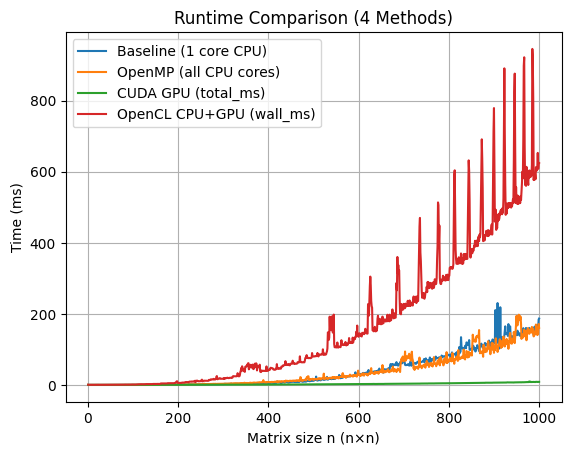

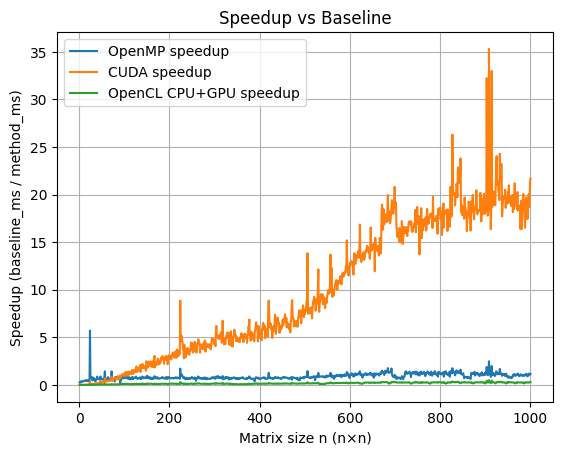

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/content"

# ---------- Load CSVs ----------
baseline_path = os.path.join(BASE_DIR, "times.csv")
openmp_path   = os.path.join(BASE_DIR, "times_openmp.csv")
cuda_path     = os.path.join(BASE_DIR, "times_cuda.csv")
opencl_hyb_path = os.path.join(BASE_DIR, "times_opencl_cpu_gpu.csv")

for p in [baseline_path, openmp_path, cuda_path, opencl_hyb_path]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing file: {p}")

baseline = pd.read_csv(baseline_path)                 # columns: n,time_ms
openmp   = pd.read_csv(openmp_path)                   # columns: n,time_ms,threads
cuda     = pd.read_csv(cuda_path)                     # columns: n,total_ms,kernel_ms,...
openclhy = pd.read_csv(opencl_hyb_path)               # columns: n,wall_ms,gpu_kernel_ms,cpu_kernel_ms,...

# Normalize column names into a common schema
baseline = baseline.rename(columns={"time_ms": "baseline_ms"})[["n", "baseline_ms"]]
openmp   = openmp.rename(columns={"time_ms": "openmp_ms"})[["n", "openmp_ms"]]
cuda     = cuda.rename(columns={"total_ms": "cuda_ms"})[["n", "cuda_ms"]]
openclhy = openclhy.rename(columns={"wall_ms": "opencl_cpu_gpu_ms"})[["n", "opencl_cpu_gpu_ms"]]

# ---------- Merge on n (inner join keeps only sizes present in all files) ----------
df = baseline.merge(openmp, on="n", how="inner") \
             .merge(cuda, on="n", how="inner") \
             .merge(openclhy, on="n", how="inner")

# ---------- Compute speedups vs baseline ----------
df["speedup_openmp"] = df["baseline_ms"] / df["openmp_ms"]
df["speedup_cuda"]   = df["baseline_ms"] / df["cuda_ms"]
df["speedup_opencl_cpu_gpu"] = df["baseline_ms"] / df["opencl_cpu_gpu_ms"]

# Save combined table
out_csv = os.path.join(BASE_DIR, "speedups_all.csv")
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)
print(df.head())

# ---------- Summary at largest available n ----------
n_max = df["n"].max()
row = df[df["n"] == n_max].iloc[0]
print("\nSummary at n =", int(n_max))
print("Baseline (ms):", row["baseline_ms"])
print("OpenMP  (ms):", row["openmp_ms"], " speedup:", row["speedup_openmp"])
print("CUDA    (ms):", row["cuda_ms"],   " speedup:", row["speedup_cuda"])
print("OpenCL CPU+GPU (ms):", row["opencl_cpu_gpu_ms"], " speedup:", row["speedup_opencl_cpu_gpu"])

# ---------- Plot: Runtime (all 4 methods on ONE chart) ----------
plt.figure()
plt.plot(df["n"], df["baseline_ms"], label="Baseline (1 core CPU)")
plt.plot(df["n"], df["openmp_ms"], label="OpenMP (all CPU cores)")
plt.plot(df["n"], df["cuda_ms"], label="CUDA GPU (total_ms)")
plt.plot(df["n"], df["opencl_cpu_gpu_ms"], label="OpenCL CPU+GPU (wall_ms)")
plt.xlabel("Matrix size n (n×n)")
plt.ylabel("Time (ms)")
plt.title("Runtime Comparison (4 Methods)")
plt.grid(True, which="both")
plt.legend()
plt.show()

# ---------- Optional: Plot Speedup vs baseline ----------
plt.figure()
plt.plot(df["n"], df["speedup_openmp"], label="OpenMP speedup")
plt.plot(df["n"], df["speedup_cuda"], label="CUDA speedup")
plt.plot(df["n"], df["speedup_opencl_cpu_gpu"], label="OpenCL CPU+GPU speedup")
plt.xlabel("Matrix size n (n×n)")
plt.ylabel("Speedup (baseline_ms / method_ms)")
plt.title("Speedup vs Baseline")
plt.grid(True, which="both")
plt.legend()
plt.show()


In [30]:
import os, glob

BASE_DIR = "/content"
csvs = sorted(glob.glob(os.path.join(BASE_DIR, "*.csv")))

print("CSV files found in /content:")
for f in csvs:
    print(" -", os.path.basename(f))


CSV files found in /content:
 - speedups_all.csv
 - times.csv
 - times_cuda.csv
 - times_opencl_cpu.csv
 - times_opencl_cpu_gpu.csv
 - times_opencl_gpu.csv
 - times_openmp.csv
